# Задача на CTF от компании QRate
**Категории**: криптография, стеганография

**Материалы**: картинка vernam.jpeg

**Текст задачи**: Вам досталась редкая диковинка: портрет Гильберта Вернама, известного криптографа. Сможете ли вы разгадать его секрет?

## Введение

**Этот документ содержит интерактивную графику, которую не поддерживают многие IDE. Чтобы гарантировать корректное отображение, открывайте его в браузере через Jupiter.**

Так как QRate - это компания, которая занимается квантовой криптографией, я хотел включить в задачу что-то связанное с ней.

Основная цель криптографии - это безопасная коммуникация, содержание которой остается в секрете. Для этого классические криптографы используют различные шифры и алгоритмы. Безопасность в них гарантируется сложностью и необычностью математики, используемой для шифрования.

Квантовая криптография в противовес этому фокусируется не на самих шифрах, но на ключах, которые в них используются. Есть ряд довольно простых шифров, гарантирующих абсолютную невозможность взлома. Единственное условие - наличие у пары коммуницирующих агентов (Алисы и Боба) одинакового истинно случайного ключа, который будет использован в процессе.

Наиболее распространенный вариант такого шифрования - это шифр Вернама: ключ и сообщение складываются по модулю два сначала Алисой для шифровки, а затем Бобом для расшифровки. При этом ключ может быть использован для шифрования только одной части сообщения одинаковой с ним длины. Именно нарушение этого правила делает возможной атаку, которую я предлагаю участникам осуществить в этой задаче.

Почему же нельзя использовать ключ несколько раз? Дело в том, что многократное повторное использование секретного ключа дает возможность сделать частотный анализ. Злоумышленник (Ева) всё еще не знает, как расшифровать те или иные зашифрованные символы, но он может посчитать их количество в потоке информации, после чего определить язык сообщения. Сопоставив гистограмму частоты символов языка с полученной, Ева может расшифровать часть символов, вычислить с их помощью ключ, и узнать содержание всего сообщения.

Этот документ устроен следующим образом: сначала мы проследим решение задачи с точки зрения участника соревнования. После этого, я расскажу, как именно создавалась задача. Такой подход позволит вам вносить изменения в структуру задачи, ведь вы будете знать её с обеих сторон. Начнем с решения.

## Часть первая: Решение задачи

Первое, что увидит участник, загрузив материалы задачи - это картинка vernam.jpeg.

<img align="left" src="materials/vernam.jpeg" alt="" width="400"/>

Даже если участник не знает, кто такой Гилберт Вернам, он может загуглить его имя. В Википедии его самая значимая работа (шифр Вернама) выделена в отдельный раздел. Отсюда участник должен понять, что задача будет связана с шифром Вернама (он также известен как одноразовый блокнот).

**Первая подсказка: шифр Вернама.**

Теперь попробуем поиграться с картинкой, чтобы найти остальные подсказки. Увеличим насыщенность цвета. Участник может сделать это в любом графическом редакторе.

In [58]:
# Для интерактивной графики.
from ipywidgets import interact
# Для работы с картинками.
from PIL import Image
# Для частотного анализа.
from collections import Counter
# Для работы с массивами при обработке картинок и не только.
import numpy as np
# Для построения графиков.
from matplotlib import pyplot as plt

In [59]:
# Функция обрезает надпись из картинки vernam.jpeg.
def prepare_image(image):
    image = image.crop((100, 625, 700, 775))
    image = image.resize((900,300))
    return image

# Загружаем картинки из материалов.
initial_image = prepare_image(Image.open("materials/vernam_photo.jpeg"))
saturated_image = prepare_image(Image.open("materials/vernam_saturated.png"))
saturated_blured_image = prepare_image(Image.open("materials/vernam_saturated_blured.png"))

# Массивы пикселей по каналам для создания цветовой маски.
saturated_blured_image_array = np.array(saturated_blured_image)
saturated_blured_image_array_HSV = np.array(saturated_blured_image.convert("HSV"))

# Отрисовка интерактивной графики.
@interact(saturation = (0.0, 1.0), mode = ['normal', 'isolate color'])
def saturate_image(mode, saturation = 0.0):
    # Режим без цветовой маски.
    if mode == 'normal':
        resulting_image = Image.blend(initial_image, saturated_image, saturation)
        display(resulting_image)
    # Режим с цветовой маской. Маска сгенерирована процедурно.
    if mode == 'isolate color':
        # Нижняя граница насыщенности.
        lower_mask = saturated_blured_image_array_HSV [:,:,2] >= 0
        # Верхняя граница насыщенности.
        upper_mask = saturated_blured_image_array_HSV [:,:,2] <= 231
        # Комбинация двух границ.
        mask = upper_mask * lower_mask
        # Фильтрация пикселей по границе.
        red = saturated_blured_image_array[:,:,0]*mask
        green = saturated_blured_image_array[:,:,1]*mask
        blue = saturated_blured_image_array[:,:,2]*mask
        isolated_mask = Image.fromarray(np.dstack((red,green,blue)))
        resulting_image_masked = Image.blend(initial_image, isolated_mask, saturation/1.3)
        display(resulting_image_masked)

interactive(children=(Dropdown(description='mode', options=('normal', 'isolate color'), value='normal'), Float…

Красным написано: same key, что намекает на то, что мы нарушили правила одноразовых блокнотов, использовав один и тот же ключ.

**Вторая подсказка: один и тот же ключ**

Зеленым написано .rar, что вместе с форматом картинки .jpeg однозначно указывает любому опытному участнику CTF соревнований, что картинку нужно открыть как архив.
*Кстати, опытный участник CTF мог бы обойтись и без этого, просто посмотрев на размер картинки. 1.52МБ это перебор для картинки размером 800x800, тем более в формате jpeg.*

**Третья подсказка: .rar**

Итак, участник знает, что задача будет связана с шифром Вернама, причем ключ будет один и тот же. Кроме того, он знает, что остальные материалы задачи стоит поискать в картинке, открыв её как архив.

Открыв картинку как архив, мы обнаруживаем ровно один бинарный файл.

Он называется "t=0110001000100010011000100110011010010110011001101001011010011001100100100010001010010010100110011001001000100010100100101001100101100111011101110110011101100110.bin" и содержит в себе одну очень длинную (40 миллионов символов) строчку, состоящую из нулей, единиц и пробелов. Пробелы стоят каждые 160 символов.

Название очевидно дает нам символ из какой-то экзотической 160-битной кодировки.

**Четвертая подсказка: длина одного символа 160 бит.**

**Пятая подсказка: зашифрованный текст - это латиница.**

Участник наверняка потратит какое-то количество времени, пытаясь раскодировать символ, сопоставив его с ASCII кодом для 't'. Это возможно (позже об этом во второй части), но кодировка довольно нетривиальна, и её декодирование не требуется для получения флага и решения задачи. Утратив надежду сломать кодировку (или разгадав её), участник перейдет к содержимому бинарного файла.

Для начала, можно попробовать найти наш символ внутри бинарного файла. Такая функция есть в любом текстовом редакторе (find).

In [60]:
# Копируем название, открываем файл.
t = "0110001000100010011000100110011010010110011001101001011010011001100100100010001010010010100110011001001000100010100100101001100101100111011101110110011101100110"
file = open("materials/t=" + t + ".bin", "r")
file_text = file.read()
# Пробуем найти код символа 't' в файле.
print(file_text.find(t))
if file_text.find(t) == -1:
    print("Не найдено!")
else:
    print("Найдено на " + str(file_text.find(t)) + " позиции.")

-1
Не найдено!


Его там не окажется. Но как же так? Зачем давать символ, которого нет в тексте? А какие вообще символы там есть? Из четвертой подсказки участник знает, что длина одного символа - 160 бит. Именно эти мысли (ну или статья на википедии про шифр Вернама и атаки на него) и должны навести участника на идею частотного анализа. Поскольку в бинарном файле есть пробелы, участник может воспользоваться онлайн-сервисом или продвинутым текстовым редактором для его осуществления.

Counter({'0000101101000101000100100000000011100010000111011110101111100000110001100101110011101010111100001111011101001110110001101100100000110100001110000010000100011011': 45227, '0000111101000101000101100000010011101101000111011110010011101111110011010101110011100001111110111111110001001110110011011100001100110101001110000010000000011010': 27095, '0000111101000001000101100000000011101101000100101110010011100000110011010101011111100001111100001111110001000101110011011100100000110101001110010010000000011011': 21606, '0000111101000101010101100100010011101101000111010001010000011111110011010101110001010001010010111111110001001110011111010111001100110101001110000011000000001010': 16918, '0000111101000101000100100000010011101101000111011110101111101111110011010101110011101010111110111111110001001110110001101100001100110101001110000010000100011010': 15831, '000011110100010101010110010000001110110100011101000101000001000011001101010111000101000101000000111111000100111001111101011110000011010

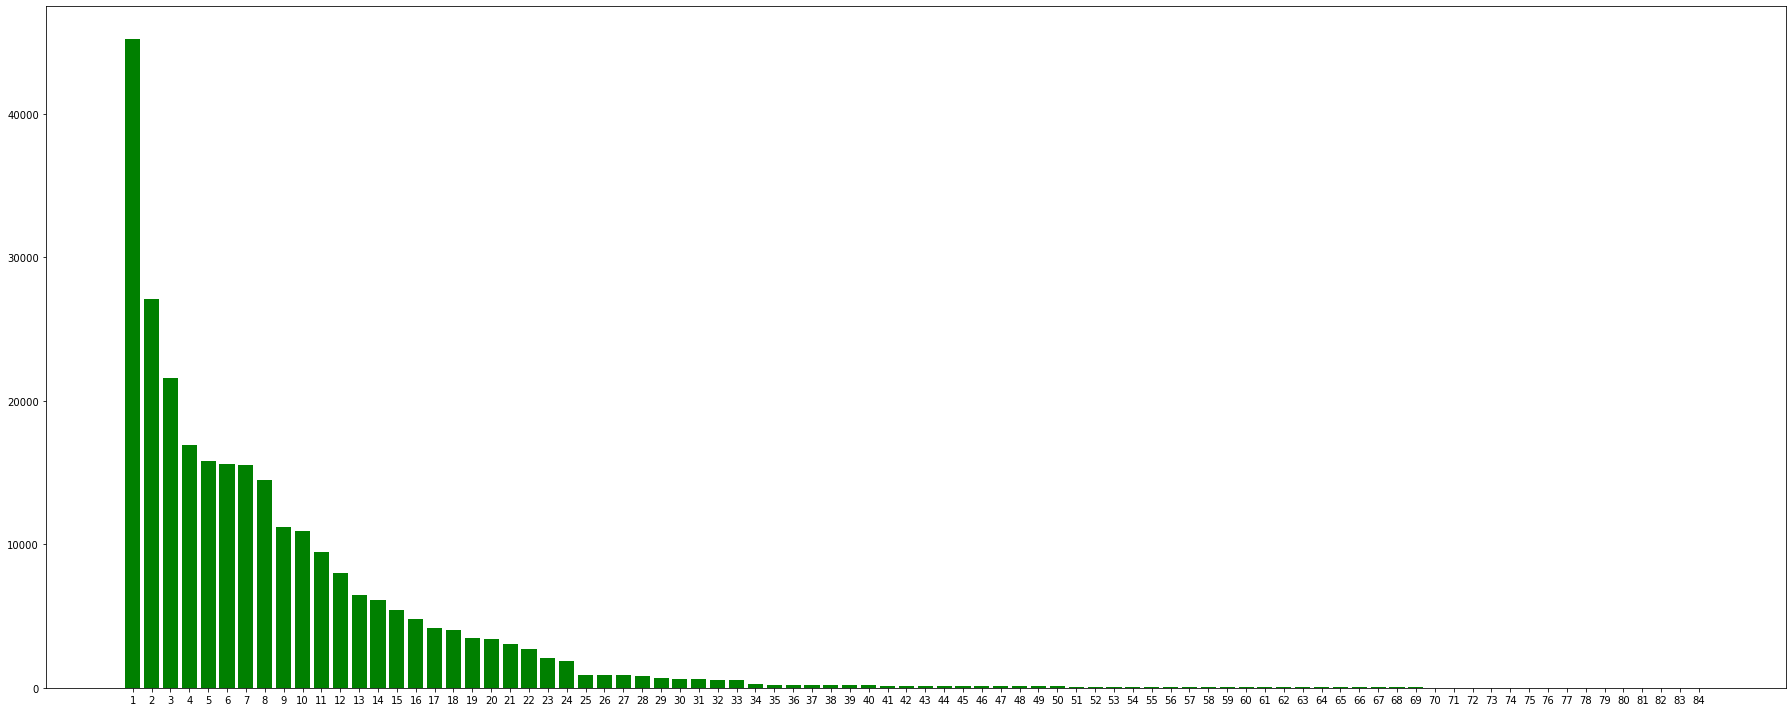

In [61]:
# Обработка файла, подсчет повторов.
file_text_array = file_text.split(' ')
file_text_array_counter = Counter(file_text_array)
file_text_array_counter_sorted = file_text_array_counter.most_common()

# Получение данных для графика.
frequencies = list((frequency[1] for frequency in file_text_array_counter_sorted))
names = list(str(number) for number in range(1, len(frequencies) + 1))

# Построение графика частот появления разных 160битных символов в файле.
plt.rcParams["figure.figsize"] = [25, 10]
plt.rcParams["figure.autolayout"] = True
plt.bar(names, frequencies, color = 'green')
plt.show()

Итак, участник знает, что в файле всего 84 разных вида символов. Самый частый из них встречается больше 40000 раз, самый редкий - ровно 1. Значит это не случайная последовательность нулей и единиц, а какой-то зашифрованный текст. При этом, буквы t, в том виде, в котором она была дана в названии, среди них нет.

А что если помимо экзотической 160битной кодировки текст также зашифрован шифром Вернама, а буква 't' дана в расшифрованном, первозданном виде? Тогда участник наверняка попробует найти букву t в зашифрованном виде. Для этого, хорошо было бы сначала определить язык, на котором написан зашифрованный в файле текст. Участник уже знает, что это латиница, поэтому следует рассмотреть самые основные варианты (английский, испанский, немецкий, французский, итальянский) и сравнить их распределения с полученным.

Участнику важно помнить, что его частотный портрет не получится идеальным, состоящим только из маленьких букв латиницы. Символов всё-таки целых 84, значит там есть и маленькие, и большие буквы, и знаки препинания, и что самое главное - пробелы. Пробел - самый распространенный знак в любом тексте, соответственно, он точно соответствует первому столбику, и его нужно убрать из выборки.

Для каждого из вариантов языков можно посчитать, насколько ожидаемый результат расходится с реальным. Это не обязательно, в нашем случае наилучший вариант видно на глаз, но мы всё равно сделаем это, чтобы убедиться.

In [62]:
# Данные пяти языков, взятые из открытого источника (https://www.sttmedia.com/)
english_frequencies  = {'E': 12.60, 'T': 9.37, 'A': 8.34, 'O': 7.70, 'N': 6.80, 'I': 6.71, 'H': 6.11, 'S': 6.11, 'R': 5.68, 'L': 4.24, 'D': 4.14, 'U': 2.85, 'C': 2.73  , 'M': 2.53, 'W': 2.34, 'Y': 2.04, 'F': 2.03, 'G': 1.92, 'P': 1.66, 'B': 1.54, 'V': 1.06, 'K': 0.87, 'J': 0.23, 'X': 0.20, 'Q': 0.09, 'Z': 0.06}
spanish_frequencies = {'E': 13.72, 'A': 11.72, 'O': 8.44, 'S': 7.20, 'N': 6.83, 'R': 6.41, 'I': 5.28, 'L': 5.24, 'D': 4.67, 'T': 4.60, 'U': 4.55, 'C': 3.87, 'M': 3.08, 'P': 2.89, 'B': 1.49, 'H': 1.18, 'Q': 1.11, 'Y': 1.09, 'V': 1.05, 'G': 1.00, 'Ó': 0.76, 'Í': 0.70, 'F': 0.69, 'J': 0.52, 'Z': 0.47, 'Á': 0.44, 'É': 0.36, 'Ñ': 0.17, 'X': 0.14, 'Ú': 0.12, 'K': 0.11, 'W': 0.04, 'Ü': 0.02}
german_frequencies = {'E': 16.93, 'N': 10.53, 'I': 8.02, 'R': 6.89, 'S': 6.42, 'T': 5.79, 'A': 5.58, 'D': 4.98, 'H': 4.98, 'U': 3.83, 'L': 3.60, 'C': 3.16, 'G': 3.02, 'M': 2.55, 'O': 2.24, 'B': 1.96, 'W': 1.78, 'F': 1.49, 'K': 1.32, 'Z': 1.21, 'V': 0.84, 'P': 0.67, 'Ü': 0.65, 'Ä': 0.54, 'ß': 0.37, 'Ö': 0.30, 'J': 0.24, 'X': 0.05, 'Y': 0.05, 'Q': 0.02}
french_frequencies = {'E': 15.10, 'A': 8.13, 'S': 7.91, 'T': 7.11, 'I': 6.94, 'R': 6.43, 'N': 6.42, 'U': 6.05, 'L': 5.68, 'O': 5.27, 'D': 3.55, 'M': 3.23, 'C': 3.15, 'P': 3.03, 'É': 2.13, 'V': 1.83, 'H': 1.08, 'G': 0.97, 'F': 0.96, 'B': 0.93, 'Q': 0.89, 'J': 0.71, 'À': 0.54, 'X': 0.42, 'È': 0.35, 'Ê': 0.24, 'Z': 0.21, 'Y': 0.19, 'K': 0.16, 'Ô': 0.07, 'Û': 0.05, 'W': 0.04, 'Â': 0.03, 'Î': 0.03, 'Ü': 0.02, 'Ù': 0.02, 'Ë': 0.01, 'Œ': 0.01, 'Ç':0.01, 'Ï': 0.01}
italian_frequencies = {'E': 11.49, 'A': 10.85, 'I': 10.18, 'O': 9.97, 'N': 7.02, 'T': 6.97, 'R': 6.19, 'L': 5.70, 'S': 5.48, 'C': 4.30, 'D': 3.39, 'U': 3.16, 'P': 2.96, 'M': 2.87, 'H': 1.43, 'B': 1.05, 'F': 1.01, 'Z': 0.85, 'Q': 0.45, 'È': 0.42, 'À': 0.15, 'Ù': 0.12, 'Ò': 0.11, 'Ì': 0.09, 'É': 0.06}
languages = {'english': english_frequencies, 'spanish': spanish_frequencies, 'german': german_frequencies, 'french': french_frequencies, 'italian': italian_frequencies}

# Отрисовка интерактивных графиков.
@interact(language = ['english', 'spanish', 'german', 'french', 'italian'])
def compare_frequencies_graph(language):
    # Сохранение выбранного языка.
    language_frequencies = languages[language]

    # Получение данных для графика.
    symbols = list(language_frequencies.keys())
    language_frequencies_array = list(language_frequencies.values())
    our_frequencies_array = list(frequency/sum(frequencies[1 : len(language_frequencies_array) + 1]) * 100 for frequency in frequencies[1 : len(language_frequencies_array) + 1])

    # Построение графика.
    x_axis = np.arange(len(symbols))
    plt.bar(x_axis - 0.2, language_frequencies_array, 0.4, color = 'orange')
    plt.bar(x_axis + 0.2, our_frequencies_array, 0.4, color = 'green')
    plt.xticks(x_axis, symbols, fontsize = 20)
    plt.show()

    # Подсчет разницы.
    difference = np.sqrt(sum((language_frequencies_array[x]-our_frequencies_array[x])**2 for x in range(len(symbols))))
    print('Расхождение: ' + str(round(difference, 2)))

interactive(children=(Dropdown(description='language', options=('english', 'spanish', 'german', 'french', 'ita…

Теперь участник точно знает, что язык сообщения - английский. Ну а судя по его распределению буква 't' - вторая по частоте. Дело за малым - побитово сложить букву из названия файла и букву из текста и получить ключ, которым был зашифрован текст. Это можно сделать в любом удобном онлайн калькуляторе или вообще на бумажке.

In [45]:
# Функция для побитового сложения.
def xor_two_letters(first, second):
    return ''.join(str(int(first[i]!=second[i])) for i in range(len(first)))

encrypted_t = file_text_array_counter_sorted[2][0]
resulting_key = xor_two_letters(t, encrypted_t)

print('Начальная буква: ' + t)
print('Найденная буква: ' + encrypted_t)
print('Полученный ключ: ' + resulting_key)

Начальная буква: 0110001000100010011000100110011010010110011001101001011010011001100100100010001010010010100110011001001000100010100100101001100101100111011101110110011101100110
Найденная буква: 0000111101000001000101100000000011101101000100101110010011100000110011010101011111100001111100001111110001000101110011011100100000110101001110010010000000011011
Полученный ключ: 0110110101100011011101000110011001111011011101000111001001111001010111110111010101110011011010010110111001100111010111110101000101010010010011100100011101111101


Что же дальше? Может быть, попробовать расшифровать весь текст? Это возможно, но не требуется для решения задачи. Всё гораздо проще! Полученный ключ - это восьмибитная последовательность UTF-8, которая и является флагом. Её можно расшифровать любым онлайн дескриптором.

In [46]:
# Функция для перевода из UTF-8 в текст.
def binary_utf8_to_string(message):
    return ''.join(chr(int(i, 2)) for i in [message[window:window + 8] for window in range(0, len(message), 8)])

print("Расшифрованный ключ: " + binary_utf8_to_string(resulting_key))

Расшифрованный ключ: mctf{try_using_QRNG}


Задача решена.

## Часть вторая: создание задачи.

Для начала, я сделал картинку. Хотелось, чтобы она была похожа на загадочный фамильный портрет с лицом Гильберта Вернама. К сожалению, в интернете есть ровно одна фотография Вернама, и она не похожа на картину ни в одном приближении. Я использовал машинное обучение, чтобы увеличить разрешение, после чего совместил получившуюся картинку со styleGAN трансфером (переносили стиль какой-то картины эпохи возрождения). После этого я прифотошопил надпись. Всё буквы в надписи имеют одинаковые характеристики Saturation (10%) и Lightness, а вот Hue разведен по трем разным полюсам (R/G/B). Именно это позволяет проявить подсказки, увеличив насыщенность цвета.

После этого, я подготовил текст. Это книжка Николя Жизана "Квантовая случайность" на английском языке, переведенная в текстовый файл и очищенная от всех невосьмибитных символов. Получившийся текст можно увидеть в файле 'quantum_chance_eng.txt'. Текст этой книжки станет подарком самым упорным участникам, расшифровавшим весь текст после сдачи флага.

In [91]:
book = open("materials/quantum_chance_eng.txt", "r")
book_text = book.read()
book.close()

print(book_text)

As a sign of our appreciation, we gift you this amazing book.

Quantum Chance: Nonlocality, Teleportation and Other Quantum Marvels.

Nicolas Gisin 
Department of Physics University of Geneva 
Geneva
Switzerland

Foreword

"Love at first sight!" was how Nicolas Gisin described his emotion when he learned about Bell's theorem. When I heard this, I relived an autumn day of 1974 when I was immersed in study of John Bell's paper, little known at the time, and understood that it was possible to render an experimental verdict on the debate between Bohr and Einstein on the interpretation of quantum mechanics. Even though a few physicists knew of the problem raised by Einstein, Podolsky, and Rosen (EPR), not many had heard of Bell's inequalities, and few were those who considered questions relating to the fundamental concepts of quantum mechanics worthy of serious attention. The EPR paper, published in 1935 in Physical Review, was readily available in university libraries, but the same could n

Чтобы убедиться, что этот текст подходит для частотного анализа, нужно сравнить частоты его символов с частотами разных языков (и убедиться, что английский самый подходящий кандидат). Кроме того, это позволит выбрать символ, который мы предложим найти участникам. Символ должен быть на одинаковой позиции в обоих графиках (не учитывая пробел). Проверим это.

In [92]:
# Получение данных для графика.
book_text_counter = Counter(book_text)
book_text_counter["/n"] = book_text_counter.pop('\n')
book_text_counter_sorted = book_text_counter.most_common()
letters = list(letter[0] for letter in book_text_counter_sorted[1:len(book_text_counter_sorted)])
frequencies = list((book_text_counter[letter] for letter in letters))

# Отрисовка интерактивных графиков.
@interact(language = ['english', 'spanish', 'german', 'french', 'italian'])
def compare_frequencies_text_graph(language):
    # Сохранение выбранного языка.
    language_frequencies = languages[language]

    # Получение данных для графика.
    symbols = list(str(list(language_frequencies.keys())[i]) + '/' + str(letters[i]) for i in range (len(language_frequencies.keys())))
    language_frequencies_array = list(language_frequencies.values())
    our_frequencies_array = list(frequency/sum(frequencies[0 : len(language_frequencies_array)]) * 100 for frequency in frequencies[0 : len(language_frequencies_array)])

    # Построение графика.
    x_axis = np.arange(len(symbols))
    plt.bar(x_axis - 0.2, language_frequencies_array, 0.4, color = 'orange')
    plt.bar(x_axis + 0.2, our_frequencies_array, 0.4, color = 'green')
    plt.xticks(x_axis, symbols, fontsize = 20)
    plt.show()

    # Подсчет разницы.
    difference = np.sqrt(sum((language_frequencies_array[x]-our_frequencies_array[x])**2 for x in range(len(symbols))))
    print('Расхождение: ' + str(round(difference, 2)))

interactive(children=(Dropdown(description='language', options=('english', 'spanish', 'german', 'french', 'ita…

Чтобы упростить задачу, я принял решение дать первую согласную букву 't'.

Для шифра Вернама мы с Элом решили использовать флаг mctf{try_using_QRNG}. QRNG - это квантовый генератор случайных чисел, именно он используется для генерации ключей в квантовых коммуникациях. Если бы мы использовали его и не повторяли ключ для шифрования каждого символа, частотный анализ и все другие атаки стали бы невозможны.

Флаг содержит ровно 20 символов, а значит в битовом представлении его длина 160 бит.

In [93]:
flag = 'mctf{try_using_QRNG}'

# Функция перевода текста в битовую строку в формате UTF-8
def string_to_binary_utf8(message):
    return ''.join(str(format(ord(letter), '08b')) for letter in message)

binary_utf8_flag = string_to_binary_utf8(flag)
print("Флаг в UTF-8: " + binary_utf8_flag)
print("Длина флага в UTF-8: " + str(len(binary_utf8_flag)))

Флаг в UTF-8: 0110110101100011011101000110011001111011011101000111001001111001010111110111010101110011011010010110111001100111010111110101000101010010010011100100011101111101
Длина флага в UTF-8: 160


Значит, кодировка, которая будет использоваться для текста книжки, должна переводить один символ в 160 бит.

Эта кодировка основана на очень простой идее. Я перевожу символ в UTF-8, и получаю 8 бит. Мне нужно 160. Запишем каждый из 8 бит, представив, что перед нами монохромный пиксельный экран, с разрешением 4x5 пикселей на символ. Единица ставится в горящий пиксель, ноль во все остальные. После этого, прочитаем получившийся 32x5 битный экран слева-направо сверху-вниз. Можете попробовать сами; введите любой восьмибитный символ:

In [94]:
# Функция для перевода битовой строки UTF-8 в пиксели.
def binary_utf8_to_binary_pixels(message):
    # Пиксели для нуля и единицы.
    numbers = [['0110',
                '1001',
                '1001',
                '1001',
                '0110'],

               ['0010',
                '0110',
                '0010',
                '0010',
                '0111']]
    return ''.join(list((numbers[message[i%8] == '1'][i//8] for i in range (40))))

# Функция для перевода текстовой строки в пиксели, основанная на функции выше.
def string_to_binary_pixels(message):
    return ''.join(binary_utf8_to_binary_pixels(string_to_binary_utf8(x)) for x in message)

symbol = input()
print('Символ: ' + symbol)

symbol_utf8 = string_to_binary_utf8(symbol)
print('\nСимвол в UTF-8: ' + symbol_utf8)

symbol_pixels = string_to_binary_pixels(symbol)
print('\nСимвол в пикселях: ')
for counter in range(5):
    line = symbol_pixels[counter*32:counter*32+32].replace('0', ' ').replace('1', '█')
    print(' '.join(symbol for symbol in [line[window:window + 4] for window in range(0, len(line), 4)]))

print('\nСимвол в пикселях (отформатированный): ')
for counter in range(5):
    line = symbol_pixels[counter*32:counter*32+32]
    print(' '.join(symbol for symbol in [line[window:window + 4] for window in range(0, len(line), 4)]))

print('\nСимвол в пикселях строчкой: ' + symbol_pixels)

e
Символ: e

Символ в UTF-8: 01100101

Символ в пикселях: 
 ██    █    █   ██   ██    █   ██    █ 
█  █  ██   ██  █  █ █  █  ██  █  █  ██ 
█  █   █    █  █  █ █  █   █  █  █   █ 
█  █   █    █  █  █ █  █   █  █  █   █ 
 ██   ███  ███  ██   ██   ███  ██   ███

Символ в пикселях (отформатированный): 
0110 0010 0010 0110 0110 0010 0110 0010
1001 0110 0110 1001 1001 0110 1001 0110
1001 0010 0010 1001 1001 0010 1001 0010
1001 0010 0010 1001 1001 0010 1001 0010
0110 0111 0111 0110 0110 0111 0110 0111

Символ в пикселях строчкой: 0110001000100110011000100110001010010110011010011001011010010110100100100010100110010010100100101001001000101001100100101001001001100111011101100110011101100111


Если принцип всё ещё не ясен, можете посмотреть реализацию этих (и многих других) функций на C++. Тут они написаны не в одну строчку: https://replit.com/@valofey/Qrate-CTF-Task#main.cpp

Форма нуля и единицы выбрана неслучайно. Ноль содержит 10 нулей и 10 единиц, единица содержит 8 единиц и 12 нулей - важно, чтобы количество было примерно одинаковым.

Кстати, такая кодировка позволяет считывать UTF-8 без дополнительных инструментов. Достаточно просто сделать окно своего текстового редактора шириной в 32 символа, и хаотичные строчки сложатся в пиксели. Но это скорее прикольная фишка, нежели изначальный замысел. Еще одна фишка связана с декодированием: если кто-то из участников догадается, как устроена кодировка, это не позволит ему сразу решить задачу, но упростит решение. Он сможет сам выбрать символ для поиска в частотном анализе (а значит выбрать пробел и пропустить фазу проверки языка).

Теперь закодируем нашу книжку нашим пиксельной кодировкой.

In [95]:
pixel_book_text = string_to_binary_pixels(book_text)

Следующий шаг - зашифровать 160битный текст книжки 8битным флагом - ключом, используя шифр Вернама.

In [96]:
# Функция для побитового сложения ключа длины n и длинного сообщения длины kn.
def xor_with_key(key, message):
    return ''.join(str(int(key[i%len(key)]!=message[i])) for i in range(len(message)))

encrypted_book_text = xor_with_key(binary_utf8_flag, pixel_book_text)

Далее поместим зашифрованный текст в бинарный файл и спрячем букву 't' в названии. Чтобы упростить частотный анализ, расставим пробелы каждые 160 символов. Подождите немного, файл появится не сразу, больше 40 миллионов символов всё-таки.

In [97]:
# Подготовка названия файла.
pixel_t = string_to_binary_pixels('t')
filename = "materials/t=" + pixel_t + ".bin"

# Запись названия и содержимого в файл.
binary_file = open(filename, "w")
encrypted_book_text_with_spaces = ' '.join(symbol for symbol in [encrypted_book_text[window:window + 160] for window in range(0, len(encrypted_book_text), 160)])
binary_file.write(encrypted_book_text_with_spaces)
binary_file.close()

Файл готов. Осталось спрятать его в картинку. Для этого (на windows):

1. Поместите текстовый файл в архив .rar
2. Откройте командную строку
3. Переместитесь в папку проекта (cd путь/к/папке)
4. Введите команду (copy /b картинка.jpeg + архив.rar картинка_с_секретом.jpeg

Задача готова.

## Заключение

Задача определенно не из простых, но решаемая. Главное, у меня получилось сделать её осмысленной и связанной с компанией QRate. Кроме того, есть приятный бонус особо пытливым участникам в форме бесплатной книжки за проделанную работу. Надеюсь, что вы примете её без изменений. Спасибо, что дочитали!

Дальше есть ряд полезных функций, которые не понадобились в тексте, но могут быть полезны при проверке задачи.

In [ ]:
# Переводит 160 бит в символ, согласно пиксельной кодировке.
def binary_pixels_to_char(bits):
    return binary_utf8_to_string(''.join(bits[i*4+33] for i in range(8)))

# Переводит пиксельную строку в текст. Работает строго на пиксельных строках без пробелов.
def binary_pixels_to_string(message):
    return ''.join(binary_pixels_to_char(i) for i in [message[window:window + 160] for window in range(0, len(message), 160)])